In [1]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

**Задача №1**

Необходимо построить векторные представления (эмбеддинги) пользователей и фильмов используя нейросетевые подходы, чтобы можно было по эмбеддингу пользователей искать похожие эмбеддинги фильмов и рекомендовать ему их.

При выполнении задания обратите внимание на:

1. **Разбиение данных на обучение и валидацию, обоснование**.

*Для каждого пользователя, выбираем последнюю по времени оценку, с учётом того, что эти пользователи уже оценили некоторое количество фильмов, превышающее определённое пороговое значение. Это даёт нам хорошее представление того процесса, который мы собираемся смоделировать.*

2. **Разбор и обоснование метрики.**

*Для тестирования модели я выбрал, такие метрики, как HR(Hit Ratio) и NDCG (Normalized Discounted Cumulative Gain), они используются, когда необходимо рекомендовать "n" лучших вариантов.*

3. **Разработка архитектуры нейронной сети с пояснениями.**

*В качестве модели была использована нейрнонная сеть, которая на вход принимает данные о пользователей и фильмах, строит из этих данных эмбеддинги пользователей и фильмов, далее эти эмбеддинги конкатенируют и подаются в полносвязанную нейронную сеть.*

4. **Обучение и валидация.**

*Модель обучалось 10 эпох, в качестве оптимизатора был выбран Adam, learning rate = 1e-2, loss function - BCE.*

In [2]:
import pandas as pd
import numpy as np
import math
import random
import torch
from torch import nn
from torch import optim
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm
from torch.nn import functional as F 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Загрузка данных**

In [3]:
ratings = pd.read_csv("/kaggle/input/movie-data/ml-latest/ratings.csv", nrows=500000)
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [4]:
n = ratings.userId.unique().shape[0]
m = ratings.movieId.unique().shape[0]

print(f'Embeddings: {n} users, {m} movies')

Embeddings: 5081 users, 17821 movies


**Предобработка данных и создание dataloader для test и train**

In [5]:
class NCF_Data(object):
    """
    Construct Dataset for NCF
    """
    def __init__(self, ratings):
        self.ratings = ratings
        self.num_ng = 4
        self.num_ng_test = 100
        self.batch_size = 256

        self.preprocess_ratings = self._reindex(self.ratings)

        self.user_pool = set(self.ratings['userId'].unique())
        self.item_pool = set(self.ratings['movieId'].unique())

        self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
        self.negatives = self._negative_sampling(self.preprocess_ratings)
        random.seed(42)

    def _reindex(self, ratings):
        """
        Process dataset to reindex userID and itemID, also set rating as binary feedback
        """
        user_list = list(ratings['userId'].drop_duplicates())
        user2id = {w: i for i, w in enumerate(user_list)}

        item_list = list(ratings['movieId'].drop_duplicates())
        item2id = {w: i for i, w in enumerate(item_list)}

        ratings['userId'] = ratings['userId'].apply(lambda x: user2id[x])
        ratings['movieId'] = ratings['movieId'].apply(lambda x: item2id[x])
        ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
        return ratings

    def _leave_one_out(self, ratings):
        """
        leave-one-out evaluation protocol
        """
        ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)
        test = ratings.loc[ratings['rank_latest'] == 1]
        train = ratings.loc[ratings['rank_latest'] > 1]
        return train[['userId', 'movieId', 'rating']], test[['userId', 'movieId', 'rating']]


    def _negative_sampling(self, ratings):
        interact_status = (
             ratings.groupby('userId')['movieId']
            .apply(set)
            .reset_index()
            .rename(columns={'movieId': 'interacted_items'}))
        interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
        interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
        return interact_status[['userId', 'negative_items', 'negative_samples']]

    def get_train_instance(self):
        users, items, ratings = [], [], []
        train_ratings = pd.merge(self.train_ratings, self.negatives[['userId', 'negative_items']], on='userId')
        train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
        for row in train_ratings.itertuples():
            users.append(int(row.userId))
            items.append(int(row.movieId))
            ratings.append(float(row.rating))
            for i in range(self.num_ng):
                users.append(int(row.userId))
                items.append(int(row.negatives[i]))
                ratings.append(float(0))  # negative samples get 0 rating
        dataset = Rating_Datset(
            user_list=users,
            item_list=items,
            rating_list=ratings)
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def get_test_instance(self):
        users, items, ratings = [], [], []
        test_ratings = pd.merge(self.test_ratings, self.negatives[['userId', 'negative_samples']], on='userId')
        for row in test_ratings.itertuples():
            users.append(int(row.userId))
            items.append(int(row.movieId))
            ratings.append(float(row.rating))
            for i in getattr(row, 'negative_samples'):
                users.append(int(row.userId))
                items.append(int(i))
                ratings.append(float(0))
        dataset = Rating_Datset(
            user_list=users,
            item_list=items,
            rating_list=ratings)
        return torch.utils.data.DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=4)


class Rating_Datset(torch.utils.data.Dataset):
    def __init__(self, user_list, item_list, rating_list):
        super(Rating_Datset, self).__init__()
        self.user_list = user_list
        self.item_list = item_list
        self.rating_list = rating_list

    def __len__(self):
        return len(self.user_list)

    def __getitem__(self, idx):
        user = self.user_list[idx]
        item = self.item_list[idx]
        rating = self.rating_list[idx]
        
        return (
            torch.tensor(user, dtype=torch.long),
            torch.tensor(item, dtype=torch.long),
            torch.tensor(rating, dtype=torch.float)
               )

In [6]:
data = NCF_Data(ratings)

/tmp/ipykernel_120/2942111383.py:52: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))


In [7]:
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

/tmp/ipykernel_120/2942111383.py:58: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to creat

**Метрики**

In [8]:

def hit(ng_item, pred_items):
    if ng_item in pred_items:
        return 1
    return 0


def ndcg(ng_item, pred_items):
    if ng_item in pred_items:
        index = pred_items.index(ng_item)
        return np.reciprocal(np.log2(index+2))
    return 0


def metrics(model, test_loader, device, top_k = 10):
    HR, NDCG = [], []

    for user, item, label in tqdm(test_loader):
        user = user.cuda()
        item = item.cuda()

        predictions = model(user, item)
        
        _, indices = torch.topk(predictions[:, 0], 10)
        recommends = torch.take(
                 item, indices).cpu().numpy().tolist()

        ng_item = item[0].item() # leave one-out evaluation has only one item per user
        HR.append(hit(ng_item, recommends))
        NDCG.append(ndcg(ng_item, recommends))

    return np.mean(HR), np.mean(NDCG)

**Модель**

In [9]:
class MLP(nn.Module):

    def __init__(self, n_users, n_items, layers=[16, 8]):
        """
        Simple Feedforward network with Embeddings for users and items
        """
        super().__init__()
        assert (layers[0] % 2 == 0), "layers[0] must be an even number"
        # user and item embedding layers
        embedding_dim = int(layers[0]/2)
        self.user_embedding = torch.nn.Embedding(n_users, embedding_dim)
        self.item_embedding = torch.nn.Embedding(n_items, embedding_dim)

        # list of weight matrices
        self.fc_layers = torch.nn.ModuleList()
        # hidden dense layers
        for _, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        # final prediction layer
        self.output_layer = torch.nn.Linear(layers[-1], 1)

    def forward(self, users, items):
        user_embedding = self.user_embedding(users)
        item_embedding = self.item_embedding(items)
        # concatenate user and item embeddings to form input
        x = torch.cat([user_embedding, item_embedding], 1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            x = self.fc_layers[idx](x)
            x = F.relu(x)
       
        logit = self.output_layer(x)
        rating = torch.sigmoid(logit)
        return rating

 

In [10]:
model = MLP(n, m, layers=[100, 200, 300])

In [11]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [12]:
model.to(device)

MLP(
  (user_embedding): Embedding(5081, 50)
  (item_embedding): Embedding(17821, 50)
  (fc_layers): ModuleList(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=300, bias=True)
  )
  (output_layer): Linear(in_features=300, out_features=1, bias=True)
)

Обучение и тестирование модели

In [13]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [14]:


best_hr = 0
hr_list = []
ndcg_list = []

for epoch in range(1, 11):
    model.train() # Enable dropout (if have).
    start_time = time.time()

    for user, item, label in tqdm(train_loader):
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        prediction = model(user, item)
        loss = loss_function(prediction[:, 0], label)
        
        
        loss.backward()
        optimizer.step()

    model.eval()
    HR, NDCG = metrics(model, test_loader, 10, device)
    hr_list.append(HR)
    ndcg_list.append(NDCG)
    print('Perfomance/HR@10', HR, epoch)
    print('Perfomance/NDCG@10', NDCG, epoch)
    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " + 
              time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

    if HR > best_hr:
        best_hr, best_ndcg, best_epoch = HR, NDCG, epoch

print("End. Best epoch {:03d}: HR = {:.3f}, NDCG = {:.3f}".format(
                                     best_epoch, best_hr, best_ndcg))

100%|██████████| 5081/5081 [00:30<00:00, 167.41it/s]


Perfomance/HR@10 0.7669750049202912 1
Perfomance/NDCG@10 0.4894166391129893 1
The time elapse of epoch 001 is: 00: 02: 04
HR: 0.767	NDCG: 0.489


100%|██████████| 5081/5081 [00:29<00:00, 171.21it/s]


Perfomance/HR@10 0.8161779177327297 2
Perfomance/NDCG@10 0.5388814091780298 2
The time elapse of epoch 002 is: 00: 02: 03
HR: 0.816	NDCG: 0.539


100%|██████████| 5081/5081 [00:30<00:00, 166.16it/s]


Perfomance/HR@10 0.8246408187364692 3
Perfomance/NDCG@10 0.5550903037520881 3
The time elapse of epoch 003 is: 00: 02: 04
HR: 0.825	NDCG: 0.555


100%|██████████| 5081/5081 [00:29<00:00, 170.97it/s]


Perfomance/HR@10 0.8338909663452077 4
Perfomance/NDCG@10 0.5610440316349776 4
The time elapse of epoch 004 is: 00: 02: 03
HR: 0.834	NDCG: 0.561


100%|██████████| 5081/5081 [00:29<00:00, 169.79it/s]


Perfomance/HR@10 0.8411729974414486 5
Perfomance/NDCG@10 0.5651722444846712 5
The time elapse of epoch 005 is: 00: 02: 03
HR: 0.841	NDCG: 0.565


100%|██████████| 5081/5081 [00:30<00:00, 167.90it/s]


Perfomance/HR@10 0.8445187955126944 6
Perfomance/NDCG@10 0.5673628960164547 6
The time elapse of epoch 006 is: 00: 02: 05
HR: 0.845	NDCG: 0.567


100%|██████████| 5081/5081 [00:29<00:00, 171.40it/s]


Perfomance/HR@10 0.8486518401889391 7
Perfomance/NDCG@10 0.570085650113665 7
The time elapse of epoch 007 is: 00: 02: 03
HR: 0.849	NDCG: 0.570


100%|██████████| 5081/5081 [00:29<00:00, 170.83it/s]


Perfomance/HR@10 0.8482582168864397 8
Perfomance/NDCG@10 0.5713478833076066 8
The time elapse of epoch 008 is: 00: 02: 02
HR: 0.848	NDCG: 0.571


100%|██████████| 5081/5081 [00:29<00:00, 170.61it/s]


Perfomance/HR@10 0.8455028537689431 9
Perfomance/NDCG@10 0.5615253842809375 9
The time elapse of epoch 009 is: 00: 02: 03
HR: 0.846	NDCG: 0.562


100%|██████████| 5081/5081 [00:29<00:00, 172.40it/s]

Perfomance/HR@10 0.8453060421176933 10
Perfomance/NDCG@10 0.572193604594681 10
The time elapse of epoch 010 is: 00: 02: 02
HR: 0.845	NDCG: 0.572
End. Best epoch 007: HR = 0.849, NDCG = 0.570


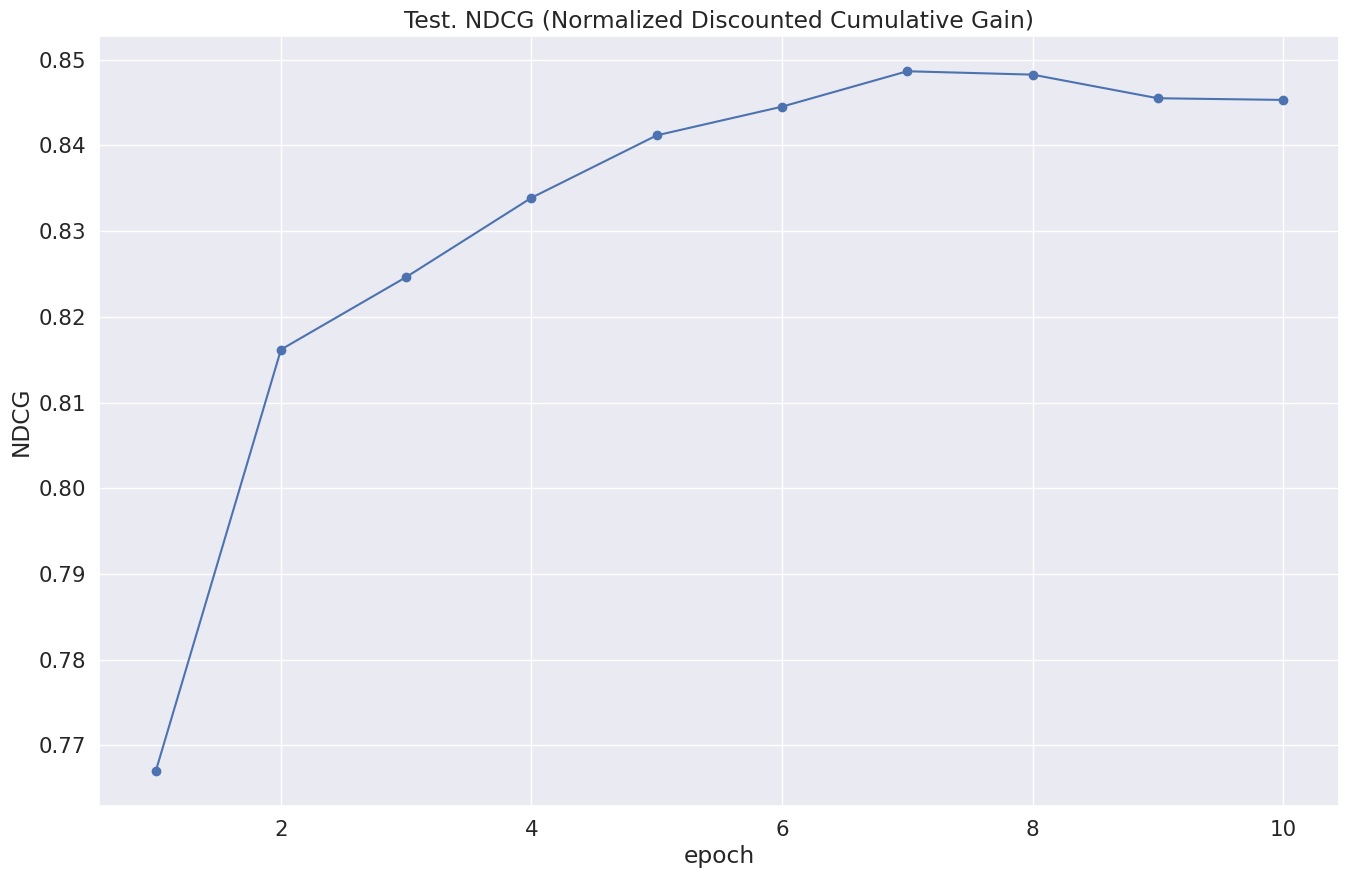

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Test. NDCG (Normalized Discounted Cumulative Gain)")
hr = np.array(hr_list)
ndcg = np.array(ndcg_list)
plt.xlabel("epoch")
plt.ylabel("NDCG")
plt.plot(range(1, 11), hr,linestyle='-', marker='o')

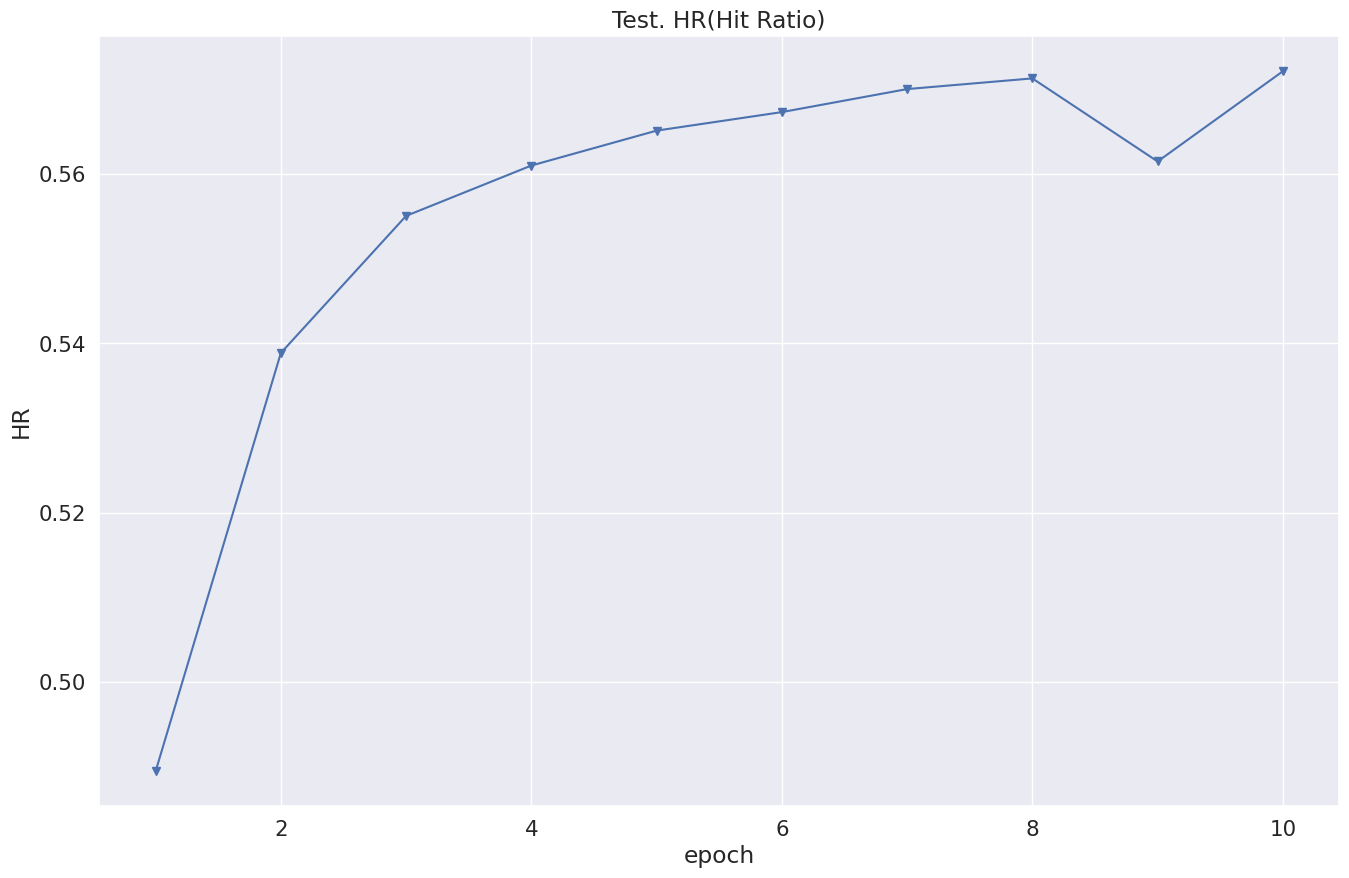

In [16]:
plt.figure(figsize=(16, 10))
plt.title("Test. HR(Hit Ratio)")
plt.xlabel("epoch")
plt.ylabel("HR")
plt.plot(range(1, 11), ndcg,linestyle='-', marker='v', label = "NDCG")